# Lineup a 1-D peak : scan detector *v* motor

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Line up a motor `m1` to a simulated diffraction peak `noisy`.

The `noisy` peak simulation (computed using EPICS PV `gp:userCalc1`) has these parameters:

parameter | description
:--- | :---
peak shape | Lorentzian as function of `m1.position`
center | randomly-placed between -1 .. +1
width | randomly-selected, at most 0.15 (motor units)
scale (height) | randomly-selected, between 10,000 .. 100,000 (counts)
counting noise| randomly-selected, between .01 .. .09 of scale (counts)

The calculation updates `noisy` when a new `m1.position` (`gp:m1.RBV`) value is reported to `gp:userCalc1`.

Since this detector is actually an EPICS calculation using the *swait* record, the concept of counting time was not built into the simulation.

Since we know the peak is somewhere between -1 .. +1, we can limit the scan range.  To ensure the scan crosses the peak, we increase the scan range a bit, to -2 .. 2.

Normally, we'd simulate a more narrow diffraction peak but the resolution of these motors is the limiting factor.

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory here so we add that to the search path before importing it.

In [ ]:
# first, load the environment variable definitions
%load_ext dotenv
%dotenv env.txt

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(".", "bluesky")))
from instrument.collection import *

I Thu-01:01:44 - ############################################################ startup
I Thu-01:01:44 - logging started
I Thu-01:01:44 - logging level = 10
I Thu-01:01:44 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/collection.py
I Thu-01:01:44 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/mpl/notebook.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
I Thu-01:01:45 - #### Bluesky Framework ####
I Thu-01:01:45 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/check_python.py
I Thu-01:01:45 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/bluesky/instrument/framework/check

Let's also monitor the simulated temperature during these scans.

In [2]:
sd.monitors.append(temperature)

## 2-pass scan

Find the peak of noisy v. m1 in the range of +/- 2.  This is a 2 scan procedure.  First scan passes through the full range.  Second scan is centered on the peak and width of the first scan.

We know the peak of the simulated noisy detector is positioned somewhere between -1 to +1.  Overscan that range to find both sides of the peak.

The plan used here comes from our instrument package, `instrument/plans/peak_finder_example.py`.  It's a custom plan that, among other activities, calls the standard bluesky plan for a scan relative to the current position.  The `bp.rel_scan()` is called twice in this custom plan.



Transient Scan ID: 195     Time: 2021-05-27 01:01:56
Persistent Unique Scan ID: 'd45fa0c9-717c-4beb-b4aa-2914e4780e28'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 01:01:59.5 |   -2.00000 |    1.18916 |
|         2 | 01:02:00.0 |   -1.81800 |    1.61178 |
|         3 | 01:02:00.5 |   -1.63600 |    2.37850 |
|         4 | 01:02:01.0 |   -1.45500 |    3.94155 |
|         5 | 01:02:01.5 |   -1.27300 |    8.07065 |
|         6 | 01:02:02.0 |   -1.09100 |   23.32589 |
|         7 | 01:02:02.5 |   -0.90900 |  215.48997 |
|         8 | 01:02:03.0 |   -0.72700 |  176.99548 |
|         9 | 01:02:03.5 |   -0.54500 |   21.33962 |
|        10 | 01:02:04.0 |   -0.36400 |    7.64079 |
|        11 | 01:02:04.5 |   -0.18200 |    3.92033 |
|        12 | 01:02:05.0 |    0.00000 |    2.35950 |
|    

('d45fa0c9-717c-4beb-b4aa-2914e4780e28',
 'bc0c570c-ca77-4b5d-8437-77143a39d46f')

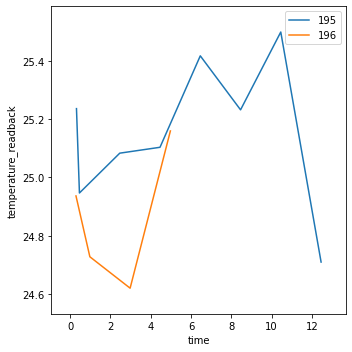

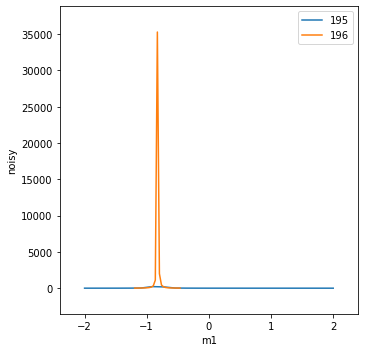

In [3]:
RE(two_pass_scan(md={"motive": "two_pass_scan"}))

## Multi-pass scan

Scan up to 4 times across the peak (in the same direction) starting 
with range of -2 .. +2, then reducing the range of the next scan 
based on the measured FWHM and centering on the measured center position (centroid).

After all scans are complete, report the computed peak centroid and FWHM for each scan in a table.  The motor will be positioned at the last centroid after the last scan.

The `findpeak_multipass` is also from our insturment package.  It calls `bp.rel_scan()` inside a loop for the desired number of iterations.



Transient Scan ID: 197     Time: 2021-05-27 01:02:34
Persistent Unique Scan ID: '92e146bf-4f80-4312-a495-d37a0581fada'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 01:02:37.1 |   -2.10000 |    0.99313 |
|         2 | 01:02:37.7 |   -1.90900 |    1.38999 |
|         3 | 01:02:38.2 |   -1.71800 |    2.07161 |
|         4 | 01:02:38.7 |   -1.52700 |    3.25654 |
|         5 | 01:02:39.2 |   -1.33600 |    6.35821 |
|         6 | 01:02:39.7 |   -1.14500 |   15.30939 |
|         7 | 01:02:40.2 |   -0.95500 |   91.26599 |
|         8 | 01:02:40.7 |   -0.76400 |  463.60566 |
|         9 | 01:02:41.2 |   -0.57300 |   25.18603 |
|        10 | 01:02:41.7 |   -0.38200 |    8.24165 |
|        11 | 01:02:42.2 |   -0.19100 |    3.94660 |
|        12 | 01:02:42.7 |    0.00000 |    2.45029 |
|    

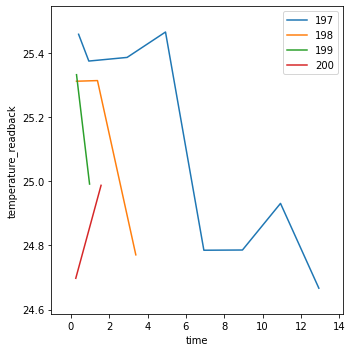

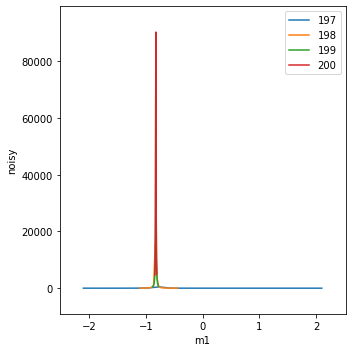

In [4]:
RE(findpeak_multipass(md={"motive": "findpeak_multipass"}))
print(f"{m1.name} now at {m1.position:.4f}")

Show how to re-plot the data from the database `db`.  We'll show the plots of the last three runs.  The measured data is always in the `primary` stream.

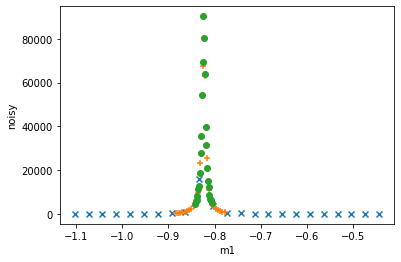

In [6]:
cat[-3].primary.read().plot.scatter(x="m1", y="noisy", marker="x")
cat[-2].primary.read().plot.scatter(x="m1", y="noisy", marker="+")
cat[-1].primary.read().plot.scatter(x="m1", y="noisy", marker="o")

Plot the monitored temperature *v* time.  (See the table of data printed during the scan, the `temperature_monitor` stream was listed near the top of the table.)

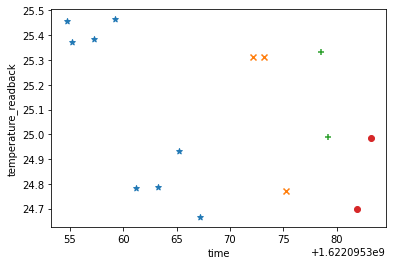

In [7]:
# temperature_monitor
cat[-4].temperature_monitor.read().plot.scatter(x="time", y="temperature_readback", marker="*")
cat[-3].temperature_monitor.read().plot.scatter(x="time", y="temperature_readback", marker="x")
cat[-2].temperature_monitor.read().plot.scatter(x="time", y="temperature_readback", marker="+")
cat[-1].temperature_monitor.read().plot.scatter(x="time", y="temperature_readback", marker="o")